# Project 3: Web APIs & NLP

---

#### 03: <b>Model tuning and insights</b>

### Contents:
- [Imports and functions](#Library-and-data-import)
- [Model Preparation](#Model-Preparation)
- [MultinomialNB (cvec)](#Multinomial-NB-(CountVectorizer))
- [MultinomialNB (tvec](#Multinomial-NB-(TfidfVectorizer))
- [Logistic Regression (cvec)](#Logistic-Regression-(CountVectorizer))
- [Logistic Regression (tvec)](#Logistic-Regression-(TfidfVectorizer))
- [Random Forests (cvec)](#Random-Forests-(CountVectorizer))
- [Random Forests (tvec)](#Random-Forests-(TfidfVectorizer))
- [ExtraTrees (cvec)](#ExtraTrees-(CountVectorizer))
- [ExtraTrees (tvec)](#ExtraTrees-(TfidfVectorizer))
- [SVM (cvec)](#SVM-(CountVectorizer))
- [SVM (tvec)](#SVM-(TfidfVectorizer))
- [Model Evaluation](#Model-Evaluation)
- [Final model tuning](#Final-model-tuning)
- [Final model interpretation & business insights](#Final-model-interpretation-and-business-insights)
- [Model limitations](#Model-limitations)
- [Recommendations on model](#Recommendations-on-model)

## Library and data import

In [1]:
# import libraries
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, plot_roc_curve
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

In [2]:
# import csv and visualize
combined_df = pd.read_csv('../datasets/combined.csv')
display(combined_df.head())
combined_df.shape

,subreddit,words
0,0,Scaling 4:6 v60 method. Do I Also Scale Pour T...
1,0,"Search: Beans With Clear Stone Fruit Note, Pre..."
2,0,What would you say is the best common coffee b...
3,0,My New Years resolution is to make better coff...
4,0,Would you buy a coffee table book with beautif...


(2808, 2)

## Model Preparation
---

**Workflow for this notebook:**
- Run Train-Test-Split on our data
- Transform data using vectorizer
- Fit model (with hyperparameter tuning) to training data
- Generate predictions using test data
- Evaluate model based on evaluation metrics
- Select best model and further improvements (e.g. via Text Normalization)

**Vectorizers used:**

`CountVectorizer` and `Tfidfvectorizer`

**Models used:**

`Random Forest`, `Multinomial Naïve Bayes`, `Logistic Regression`

**Evaluation metrics used:**

As there is no class imbalance ('1' = 0.504, '0' = 0.496), the classification metric used will be `accuracy` - a measure of the proportion of true predictions over all predictions. Furthermore, the main aim is not to minimize either False Positives or False Negatives, because ideally, both should be as low as possible (i.e. improper classifying of posts is equally bad). We will also be visualizing the best categorization method to be our final model by plotting the `ROC-AUC` curve.

**Text Normalization used:**

`Lemmatization` and `Snowball Stemmer`

### Customise stopwords

Explain why we use sklearn stopwords + explain why we add these words from N-grams analysis.

In [3]:
# the default sklearn stopword list
stop_words = text.ENGLISH_STOP_WORDS  

# add additional stopwords
additional_stopwords = {'coffee','tea','just','like','use','teas','ve','make','know'}
stop_words = stop_words.union(additional_stopwords)

# create custom stopword list
my_stop_words = stop_words.union(additional_stopwords)


### Train-Test-Split

In [4]:
# create input and output variables
X = combined_df['words']
y = combined_df['subreddit']

# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

### Baseline Accuracy

We need to calculate baseline accuracy in order to tell if our model is better than null model (predicting the plurality of class).

In [5]:
y_test.value_counts(normalize = True)

1    0.503776
0    0.496224
Name: subreddit, dtype: float64

## Modeling with Hyperparameter tuning
---

### Functions for modeling

In [6]:
# function to generate various train/test accuracies & confusion matrix
def evaluation_metrics(gs,model,vect):
    print(f"Best CV score: {gs.best_score_}")
    print(f"Best params: {gs.best_params_}")
    print(f"Train Score: {gs.score(X_train, y_train)}")
    print(f"Test Score: {gs.score(X_test, y_test)}")
    pred = gs.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');
    print(classification_report(y_test, pred))
    cross_val_score_list.append(gs.best_score_)
    acc_train_list.append(gs.score(X_train, y_train))
    acc_test_list.append(gs.score(X_test, y_test))
    model_name_list.append(model)
    vect_name_list.append(vect)
    fp_list.append(fp)
    fn_list.append(fn)

In [7]:
# create lists to store modeling results
cross_val_score_list = []
acc_train_list = []
acc_test_list = []
model_name_list = []
vect_name_list = []
fn_list = []
fp_list = []

### <u>Naïve Bayes [Benchmark Model]</u>

Naïve Bayes classifier is a probabilistic mahine learning model that is commonly used in classification problems. It relies on Bayes Theorem, which is a way of finding a probability when we know certain other probabilities. In this case, we want to calculate the probability that a post is classified under `r/tea` instead of `r/Coffee` subreddit given the words in the posts and title.

We will be using `Multinomial Naive Bayes` bacause it works with occurrence counts (features are positive discrete integers), while Bernoullii Naive Bayes is designed for binaary/boolean features.

However, limitations of the Naive Bayes model is that it makes the assumption that all features are independent of one another in which text data is never independent (i.e. certain words can change the context of a sentence when used with other words. 

Despite this assumption not being realistic with NLP data, we still use Naïve Bayes pretty frequently.
- It's a very fast modeling algorithm (which is great especially when we have lots of features and/or lots of data!).
- It is often an excellent classifier, outperforming more complicated models.

Hence, this would be our **benchmark model**.

### Multinomial NB (CountVectorizer)

In [8]:
# create pipeline for vectorizer and estimator
pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [9]:
pipe1.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'nb': MultinomialNB(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [10]:
pipe_params1 = {
    'cvec__max_features': [None, 15_000], # selecting top N words from entire corpus
    'cvec__min_df':[2,3,4], # word must occur in at least N documents in corpus
    'cvec__max_df':[0.5,0.6,0.4], # ignore words that occur in >N% of the documents in corpus
    'cvec__ngram_range': [(1,1), (1,2)], # words from unigram / words from unigram + bigram
    'cvec__stop_words': [my_stop_words], # stopwords from sklearn + custom words
    'nb__fit_prior': [True, False]
}

In [11]:
# instantiate GridSearchCV
gs1 = GridSearchCV(pipe1, pipe_params1, cv = 5)

# fit gridsearch
gs1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.5, 0.6, 0.4],
                         'cvec__max_features': [None, 15000],
                         'cvec__min_df': [2, 3, 4],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                                                         'always', 'am

Best CV score: 0.8463626615497489
Best params: {'cvec__max_df': 0.5, 'cvec__max_features': None, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': frozenset({'fifty', 'thereupon', 'empty', 'many', 'nowhere', 'these', 'four', 'just', 'my', 'while', 'mine', 'serious', 'beside', 'what', 'whither', 'seems', 'amoungst', 'always', 'as', 'mostly', 'yourself', 'amongst', 'their', 'through', 'move', 'thence', 'do', 'thereafter', 'everywhere', 'nine', 'within', 'formerly', 'how', 'such', 'forty', 'seemed', 'back', 'alone', 'etc', 'hereby', 'since', 'another', 'keep', 'him', 'therefore', 'whoever', 'again', 'among', 'five', 'mill', 'whereby', 'wherein', 'after', 'whether', 'fire', 'has', 'six', 'bottom', 'namely', 'get', 'very', 'per', 'eight', 'her', 'found', 'none', 'above', 'often', 'still', 'well', 'no', 'wherever', 'upon', 'hundred', 'are', 'eg', 'itself', 'front', 'without', 'thick', 'that', 'towards', 'ourselves', 'eleven', 'against', 'others', 'whereas', 'couldnt', 'less

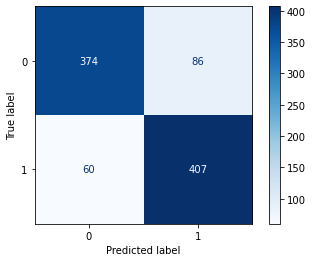

In [12]:
# generate evaluation metrics and confusion matrix
evaluation_metrics(gs1, 'MultinomialNB', 'CountVectorizer')

### Multinomial NB (TfidfVectorizer)

In [13]:
# create pipeline for vectorizer and estimator
pipe2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [14]:
pipe2.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'nb': MultinomialNB(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [15]:
pipe_params2 = {
    'tvec__max_features': [None, 15_000],
    'tvec__min_df':[2,3,4],
    'tvec__max_df':[0.5,0.6,0.4],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words': [my_stop_words],
    'nb__fit_prior': [True, False]
}

In [16]:
# instantiate GridSearchCV
gs2 = GridSearchCV(pipe2, pipe_params2, cv = 5)

# fit gridsearch
gs2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'nb__fit_prior': [True, False],
                         'tvec__max_df': [0.5, 0.6, 0.4],
                         'tvec__max_features': [None, 15000],
                         'tvec__min_df': [2, 3, 4],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
             

Best CV score: 0.850617980698685
Best params: {'nb__fit_prior': True, 'tvec__max_df': 0.5, 'tvec__max_features': None, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': frozenset({'fifty', 'thereupon', 'empty', 'many', 'nowhere', 'these', 'four', 'just', 'my', 'while', 'mine', 'serious', 'beside', 'what', 'whither', 'seems', 'amoungst', 'always', 'as', 'mostly', 'yourself', 'amongst', 'their', 'through', 'move', 'thence', 'do', 'thereafter', 'everywhere', 'nine', 'within', 'formerly', 'how', 'such', 'forty', 'seemed', 'back', 'alone', 'etc', 'hereby', 'since', 'another', 'keep', 'him', 'therefore', 'whoever', 'again', 'among', 'five', 'mill', 'whereby', 'wherein', 'after', 'whether', 'fire', 'has', 'six', 'bottom', 'namely', 'get', 'very', 'per', 'eight', 'her', 'found', 'none', 'above', 'often', 'still', 'well', 'no', 'wherever', 'upon', 'hundred', 'are', 'eg', 'itself', 'front', 'without', 'thick', 'that', 'towards', 'ourselves', 'eleven', 'against', 'others', 'wher

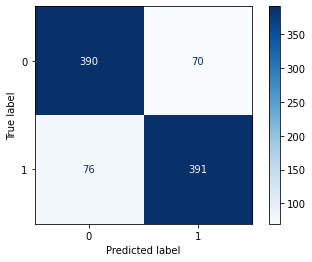

In [17]:
# generate evaluation metrics and confusion matrix
evaluation_metrics(gs2, 'MultinomialNB', 'TfidfVectorizer')

### <u>Logistic Regression Model</u>

### Logistic Regression (CountVectorization)

In [18]:
# create pipeline for vectorizer and estimator
pipe3 = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression(n_jobs = -1))
])

In [19]:
pipe3.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()),
  ('logreg', LogisticRegression(n_jobs=-1))],
 'verbose': False,
 'cvec': CountVectorizer(),
 'logreg': LogisticRegression(n_jobs=-1),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'logreg__C': 1.0,
 'logreg__class_weight': None,
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__l1_ratio': None,
 'logreg__max_iter': 100,
 'logreg__multi_class': 'auto',
 'logreg__n_jobs': -1,
 'logreg__penalty': 'l2',
 'logreg__random_state': None,
 'logreg__solver': 'lbfgs

In [20]:
pipe_params3 = {
    'cvec__max_features': [None, 15_000],
    'cvec__min_df':[2,3,4],
    'cvec__max_df':[0.5,0.6,0.4],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': [my_stop_words],
    'logreg__class_weight': [None, 'balanced'],
    'logreg__solver': ['lbfgs','newton-cg']
}

In [21]:
# instantiate GridSearchCV
gs3 = GridSearchCV(pipe3, pipe_params3, cv = 5)

# fit gridsearch
gs3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logreg',
                                        LogisticRegression(n_jobs=-1))]),
             param_grid={'cvec__max_df': [0.5, 0.6, 0.4],
                         'cvec__max_features': [None, 15000],
                         'cvec__min_df': [2, 3, 4],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
            

Best CV score: 0.8282944861448163
Best params: {'cvec__max_df': 0.5, 'cvec__max_features': None, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': frozenset({'fifty', 'thereupon', 'empty', 'many', 'nowhere', 'these', 'four', 'just', 'my', 'while', 'mine', 'serious', 'beside', 'what', 'whither', 'seems', 'amoungst', 'always', 'as', 'mostly', 'yourself', 'amongst', 'their', 'through', 'move', 'thence', 'do', 'thereafter', 'everywhere', 'nine', 'within', 'formerly', 'how', 'such', 'forty', 'seemed', 'back', 'alone', 'etc', 'hereby', 'since', 'another', 'keep', 'him', 'therefore', 'whoever', 'again', 'among', 'five', 'mill', 'whereby', 'wherein', 'after', 'whether', 'fire', 'has', 'six', 'bottom', 'namely', 'get', 'very', 'per', 'eight', 'her', 'found', 'none', 'above', 'often', 'still', 'well', 'no', 'wherever', 'upon', 'hundred', 'are', 'eg', 'itself', 'front', 'without', 'thick', 'that', 'towards', 'ourselves', 'eleven', 'against', 'others', 'whereas', 'couldnt', 'less

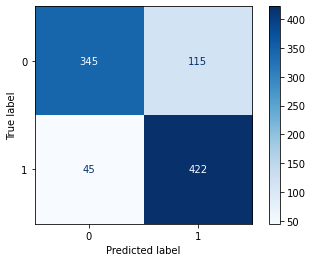

In [22]:
# generate evaluation metrics and confusion matrix
evaluation_metrics(gs3, 'LogisticRegression', 'CountVectorizer')

### Logistic Regression (TfidfVectorizer)

In [23]:
# create pipeline for vectorizer and estimator
pipe4 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression(n_jobs = -1))
])

In [24]:
pipe_params4 = {
    'tvec__max_features': [None, 15_000],
    'tvec__min_df':[2,3,4],
    'tvec__max_df':[0.5,0.6,0.4],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words': [my_stop_words],
    'logreg__class_weight': [None, 'balanced'],
    'logreg__solver': ['lbfgs','newton-cg']
}

In [25]:
# instantiate GridSearchCV
gs4 = GridSearchCV(pipe4, pipe_params4, cv = 5)

# fit gridsearch
gs4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg',
                                        LogisticRegression(n_jobs=-1))]),
             param_grid={'logreg__class_weight': [None, 'balanced'],
                         'logreg__solver': ['lbfgs', 'newton-cg'],
                         'tvec__max_df': [0.5, 0.6, 0.4],
                         'tvec__max_features': [None, 15000],
                         'tvec__min_df': [2, 3, 4],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                              

Best CV score: 0.8442335910604436
Best params: {'logreg__class_weight': 'balanced', 'logreg__solver': 'lbfgs', 'tvec__max_df': 0.5, 'tvec__max_features': None, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': frozenset({'fifty', 'thereupon', 'empty', 'many', 'nowhere', 'these', 'four', 'just', 'my', 'while', 'mine', 'serious', 'beside', 'what', 'whither', 'seems', 'amoungst', 'always', 'as', 'mostly', 'yourself', 'amongst', 'their', 'through', 'move', 'thence', 'do', 'thereafter', 'everywhere', 'nine', 'within', 'formerly', 'how', 'such', 'forty', 'seemed', 'back', 'alone', 'etc', 'hereby', 'since', 'another', 'keep', 'him', 'therefore', 'whoever', 'again', 'among', 'five', 'mill', 'whereby', 'wherein', 'after', 'whether', 'fire', 'has', 'six', 'bottom', 'namely', 'get', 'very', 'per', 'eight', 'her', 'found', 'none', 'above', 'often', 'still', 'well', 'no', 'wherever', 'upon', 'hundred', 'are', 'eg', 'itself', 'front', 'without', 'thick', 'that', 'towards', 'ourselv

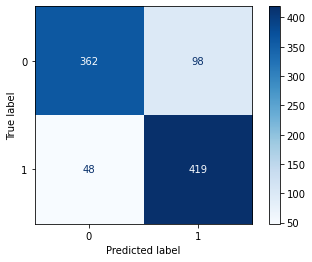

In [26]:
# generate evaluation metrics and confusion matrix
evaluation_metrics(gs4, 'LogisticRegression', 'TfidfVectorizer')

### <u>Random Forests / ExtraTrees Classifier</u>

### Random Forests (CountVectorization)

In [27]:
# create pipeline for vectorizer and estimator
pipe5 = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier(n_jobs = -1))
])

In [28]:
pipe5.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()),
  ('rf', RandomForestClassifier(n_jobs=-1))],
 'verbose': False,
 'cvec': CountVectorizer(),
 'rf': RandomForestClassifier(n_jobs=-1),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_impurity_split': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split':

In [29]:
pipe_params5 = {
    'cvec__max_features': [None, 15_000],
    'cvec__min_df':[2,3,4],
    'cvec__max_df':[0.5,0.6,0.4],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': [my_stop_words],
    'rf__n_estimators': [100,150],
    'rf__min_samples_split': [2,10,20]
}

In [30]:
# instantiate GridSearchCV
gs5 = GridSearchCV(pipe5, pipe_params5, cv = 5)

# fit gridsearch
gs5.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=-1))]),
             param_grid={'cvec__max_df': [0.5, 0.6, 0.4],
                         'cvec__max_features': [None, 15000],
                         'cvec__min_df': [2, 3, 4],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
            

Best CV score: 0.8224476550595405
Best params: {'cvec__max_df': 0.5, 'cvec__max_features': 15000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': frozenset({'fifty', 'thereupon', 'empty', 'many', 'nowhere', 'these', 'four', 'just', 'my', 'while', 'mine', 'serious', 'beside', 'what', 'whither', 'seems', 'amoungst', 'always', 'as', 'mostly', 'yourself', 'amongst', 'their', 'through', 'move', 'thence', 'do', 'thereafter', 'everywhere', 'nine', 'within', 'formerly', 'how', 'such', 'forty', 'seemed', 'back', 'alone', 'etc', 'hereby', 'since', 'another', 'keep', 'him', 'therefore', 'whoever', 'again', 'among', 'five', 'mill', 'whereby', 'wherein', 'after', 'whether', 'fire', 'has', 'six', 'bottom', 'namely', 'get', 'very', 'per', 'eight', 'her', 'found', 'none', 'above', 'often', 'still', 'well', 'no', 'wherever', 'upon', 'hundred', 'are', 'eg', 'itself', 'front', 'without', 'thick', 'that', 'towards', 'ourselves', 'eleven', 'against', 'others', 'whereas', 'couldnt', 'les

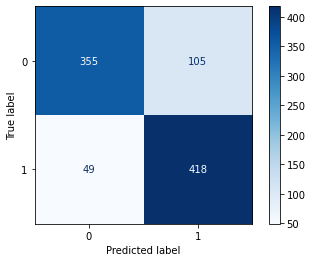

In [31]:
# generate evaluation metrics and confusion matrix
evaluation_metrics(gs5, 'Random Forests', 'CountVectorizer')

### Random Forests (TfifdVectorization)

In [32]:
# create pipeline for vectorizer and estimator
pipe6 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier(n_jobs = -1))
])

In [33]:
pipe_params6 = {
    'tvec__max_features': [None, 15_000],
    'tvec__min_df':[2,3,4],
    'tvec__max_df':[0.5,0.6,0.4],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words': [my_stop_words],
    'rf__n_estimators': [100,150],
    'rf__min_samples_split': [2,10,20]
}

In [34]:
# instantiate GridSearchCV
gs6 = GridSearchCV(pipe6, pipe_params6, cv = 5)

# fit gridsearch
gs6.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=-1))]),
             param_grid={'rf__min_samples_split': [2, 10, 20],
                         'rf__n_estimators': [100, 150],
                         'tvec__max_df': [0.5, 0.6, 0.4],
                         'tvec__max_features': [None, 15000],
                         'tvec__min_df': [2, 3, 4],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                              

Best CV score: 0.8197767932727581
Best params: {'rf__min_samples_split': 2, 'rf__n_estimators': 150, 'tvec__max_df': 0.6, 'tvec__max_features': 15000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': frozenset({'fifty', 'thereupon', 'empty', 'many', 'nowhere', 'these', 'four', 'just', 'my', 'while', 'mine', 'serious', 'beside', 'what', 'whither', 'seems', 'amoungst', 'always', 'as', 'mostly', 'yourself', 'amongst', 'their', 'through', 'move', 'thence', 'do', 'thereafter', 'everywhere', 'nine', 'within', 'formerly', 'how', 'such', 'forty', 'seemed', 'back', 'alone', 'etc', 'hereby', 'since', 'another', 'keep', 'him', 'therefore', 'whoever', 'again', 'among', 'five', 'mill', 'whereby', 'wherein', 'after', 'whether', 'fire', 'has', 'six', 'bottom', 'namely', 'get', 'very', 'per', 'eight', 'her', 'found', 'none', 'above', 'often', 'still', 'well', 'no', 'wherever', 'upon', 'hundred', 'are', 'eg', 'itself', 'front', 'without', 'thick', 'that', 'towards', 'ourselves', 'ele

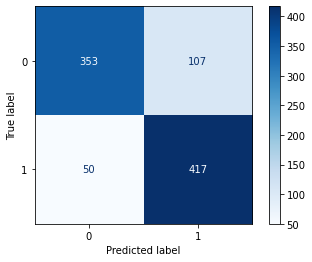

In [35]:
# generate evaluation metrics and confusion matrix
evaluation_metrics(gs6, 'Random Forests', 'TfidfVectorizer')

### ExtraTrees (CountVectorizer)

In [36]:
# create pipeline for vectorizer and estimator
pipe7 = Pipeline([
    ('cvec', CountVectorizer()),
    ('et', ExtraTreesClassifier(n_jobs = -1))
])

In [37]:
pipe_params7 = {
    'cvec__max_features': [None, 15_000],
    'cvec__min_df':[2,3,4],
    'cvec__max_df':[0.5,0.6,0.4],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': [my_stop_words],
    'et__n_estimators': [100,150],
    'et__min_samples_split': [2,10,20]
}

In [38]:
# instantiate GridSearchCV
gs7 = GridSearchCV(pipe7, pipe_params7, cv = 5)

# fit gridsearch
gs7.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('et',
                                        ExtraTreesClassifier(n_jobs=-1))]),
             param_grid={'cvec__max_df': [0.5, 0.6, 0.4],
                         'cvec__max_features': [None, 15000],
                         'cvec__min_df': [2, 3, 4],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
              

Best CV score: 0.8198007788249901
Best params: {'cvec__max_df': 0.6, 'cvec__max_features': 15000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': frozenset({'fifty', 'thereupon', 'empty', 'many', 'nowhere', 'these', 'four', 'just', 'my', 'while', 'mine', 'serious', 'beside', 'what', 'whither', 'seems', 'amoungst', 'always', 'as', 'mostly', 'yourself', 'amongst', 'their', 'through', 'move', 'thence', 'do', 'thereafter', 'everywhere', 'nine', 'within', 'formerly', 'how', 'such', 'forty', 'seemed', 'back', 'alone', 'etc', 'hereby', 'since', 'another', 'keep', 'him', 'therefore', 'whoever', 'again', 'among', 'five', 'mill', 'whereby', 'wherein', 'after', 'whether', 'fire', 'has', 'six', 'bottom', 'namely', 'get', 'very', 'per', 'eight', 'her', 'found', 'none', 'above', 'often', 'still', 'well', 'no', 'wherever', 'upon', 'hundred', 'are', 'eg', 'itself', 'front', 'without', 'thick', 'that', 'towards', 'ourselves', 'eleven', 'against', 'others', 'whereas', 'couldnt', 'les

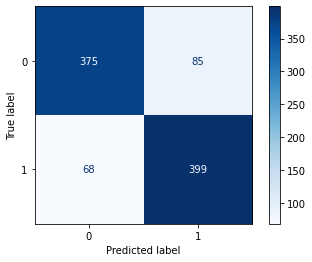

In [39]:
evaluation_metrics(gs7, 'ExtraTrees', 'CountVectorizer')

### ExtraTrees (TfidfVectorizer)

In [40]:
# create pipeline for vectorizer and estimator
pipe8 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('et', ExtraTreesClassifier(n_jobs = -1))
])

In [41]:
pipe_params8 = {
    'tvec__max_features': [None, 15_000],
    'tvec__min_df':[2,3,4],
    'tvec__max_df':[0.5,0.6,0.4],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words': [my_stop_words],
    'et__n_estimators': [100,150],
    'et__min_samples_split': [2,10,20]
}

In [42]:
# instantiate GridSearchCV
gs8 = GridSearchCV(pipe7, pipe_params7, cv = 5)

# fit gridsearch
gs8.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('et',
                                        ExtraTreesClassifier(n_jobs=-1))]),
             param_grid={'cvec__max_df': [0.5, 0.6, 0.4],
                         'cvec__max_features': [None, 15000],
                         'cvec__min_df': [2, 3, 4],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
              

Best CV score: 0.8208603758677127
Best params: {'cvec__max_df': 0.5, 'cvec__max_features': 15000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': frozenset({'fifty', 'thereupon', 'empty', 'many', 'nowhere', 'these', 'four', 'just', 'my', 'while', 'mine', 'serious', 'beside', 'what', 'whither', 'seems', 'amoungst', 'always', 'as', 'mostly', 'yourself', 'amongst', 'their', 'through', 'move', 'thence', 'do', 'thereafter', 'everywhere', 'nine', 'within', 'formerly', 'how', 'such', 'forty', 'seemed', 'back', 'alone', 'etc', 'hereby', 'since', 'another', 'keep', 'him', 'therefore', 'whoever', 'again', 'among', 'five', 'mill', 'whereby', 'wherein', 'after', 'whether', 'fire', 'has', 'six', 'bottom', 'namely', 'get', 'very', 'per', 'eight', 'her', 'found', 'none', 'above', 'often', 'still', 'well', 'no', 'wherever', 'upon', 'hundred', 'are', 'eg', 'itself', 'front', 'without', 'thick', 'that', 'towards', 'ourselves', 'eleven', 'against', 'others', 'whereas', 'couldnt', 'les

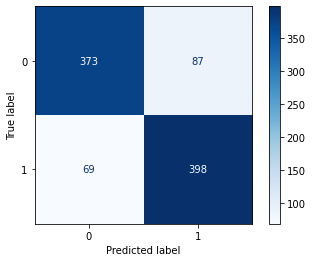

In [43]:
# generate evaluation metrics and confusion matrix
evaluation_metrics(gs8, 'ExtraTrees', 'TfidfVectorizer')

### <u>Support Vector Machine Classifier</u>

### SVM (CountVectorizer) 

In [44]:
# create pipeline for vectorizer and estimator
pipe9 = Pipeline([
    ('cvec', CountVectorizer()),
    ('svc', SVC(max_iter = 20_000))
])

In [45]:
pipe9.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('svc', SVC(max_iter=20000))],
 'verbose': False,
 'cvec': CountVectorizer(),
 'svc': SVC(max_iter=20000),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': 20000,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__ve

In [46]:
pipe_params9 = {
    'cvec__max_features': [None, 15_000],
    'cvec__min_df':[2,3,4],
    'cvec__max_df':[0.5,0.6,0.4],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': [my_stop_words],
    'svc__kernel': ['rbf','poly'],
    'svc__degree': [2,3]
}

In [47]:
# instantiate GridSearchCV
gs9 = GridSearchCV(pipe9, pipe_params9, cv = 5)

# fit gridsearch
gs9.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('svc', SVC(max_iter=20000))]),
             param_grid={'cvec__max_df': [0.5, 0.6, 0.4],
                         'cvec__max_features': [None, 15000],
                         'cvec__min_df': [2, 3, 4],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                                                         'always'

Best CV score: 0.754918449122411
Best params: {'cvec__max_df': 0.5, 'cvec__max_features': None, 'cvec__min_df': 4, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': frozenset({'fifty', 'thereupon', 'empty', 'many', 'nowhere', 'these', 'four', 'just', 'my', 'while', 'mine', 'serious', 'beside', 'what', 'whither', 'seems', 'amoungst', 'always', 'as', 'mostly', 'yourself', 'amongst', 'their', 'through', 'move', 'thence', 'do', 'thereafter', 'everywhere', 'nine', 'within', 'formerly', 'how', 'such', 'forty', 'seemed', 'back', 'alone', 'etc', 'hereby', 'since', 'another', 'keep', 'him', 'therefore', 'whoever', 'again', 'among', 'five', 'mill', 'whereby', 'wherein', 'after', 'whether', 'fire', 'has', 'six', 'bottom', 'namely', 'get', 'very', 'per', 'eight', 'her', 'found', 'none', 'above', 'often', 'still', 'well', 'no', 'wherever', 'upon', 'hundred', 'are', 'eg', 'itself', 'front', 'without', 'thick', 'that', 'towards', 'ourselves', 'eleven', 'against', 'others', 'whereas', 'couldnt', 'less'

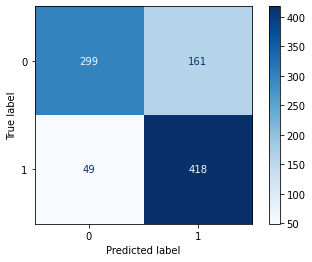

In [48]:
# generate evaluation metrics and confusion matrix
evaluation_metrics(gs9, 'SVM', 'CountVectorizer')

### SVM (TfidfVectorizer)

In [49]:
# create pipeline for vectorizer and estimator
pipe10 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svc', SVC(max_iter = 20_000))
])

In [50]:
pipe_params10 = {
    'tvec__max_features': [None, 15_000],
    'tvec__min_df':[2,3,4],
    'tvec__max_df':[0.5,0.6,0.4],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__stop_words': [my_stop_words],
    'svc__kernel': ['rbf','poly'],
    'svc__degree': [2,3]
}

In [51]:
# instantiate GridSearchCV
gs10 = GridSearchCV(pipe10, pipe_params10, cv = 5)

# fit gridsearch
gs10.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('svc', SVC(max_iter=20000))]),
             param_grid={'svc__degree': [2, 3], 'svc__kernel': ['rbf', 'poly'],
                         'tvec__max_df': [0.5, 0.6, 0.4],
                         'tvec__max_features': [None, 15000],
                         'tvec__min_df': [2, 3, 4],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also

Best CV score: 0.8383782944861448
Best params: {'svc__degree': 2, 'svc__kernel': 'poly', 'tvec__max_df': 0.5, 'tvec__max_features': None, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': frozenset({'fifty', 'thereupon', 'empty', 'many', 'nowhere', 'these', 'four', 'just', 'my', 'while', 'mine', 'serious', 'beside', 'what', 'whither', 'seems', 'amoungst', 'always', 'as', 'mostly', 'yourself', 'amongst', 'their', 'through', 'move', 'thence', 'do', 'thereafter', 'everywhere', 'nine', 'within', 'formerly', 'how', 'such', 'forty', 'seemed', 'back', 'alone', 'etc', 'hereby', 'since', 'another', 'keep', 'him', 'therefore', 'whoever', 'again', 'among', 'five', 'mill', 'whereby', 'wherein', 'after', 'whether', 'fire', 'has', 'six', 'bottom', 'namely', 'get', 'very', 'per', 'eight', 'her', 'found', 'none', 'above', 'often', 'still', 'well', 'no', 'wherever', 'upon', 'hundred', 'are', 'eg', 'itself', 'front', 'without', 'thick', 'that', 'towards', 'ourselves', 'eleven', 'agains

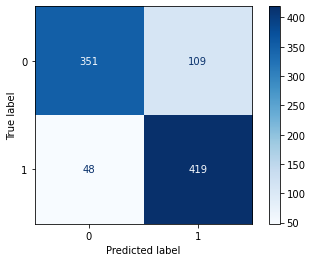

In [52]:
# generate evaluation metrics and confusion matrix
evaluation_metrics(gs10, 'SVM', 'TfidfVectorizer')

## Model Evaluation
---

In [53]:
# create dataframe containing model performances
performance = pd.DataFrame({'Model': model_name_list,
                           'Vectorizer': vect_name_list,
                           'Train Score': acc_train_list,
                           'Test Score': acc_test_list,
                           'Best CV Score': cross_val_score_list,
                           'False Positives': fp_list,
                           'False Negatives': fn_list})

performance.sort_values(by=['Test Score'], ascending = False)

,Model,Vectorizer,Train Score,Test Score,Best CV Score,False Positives,False Negatives
0,MultinomialNB,CountVectorizer,0.903243,0.842503,0.846363,86,60
1,MultinomialNB,TfidfVectorizer,0.961722,0.842503,0.850618,70,76
3,LogisticRegression,TfidfVectorizer,0.967039,0.842503,0.844234,98,48
6,ExtraTrees,CountVectorizer,0.987241,0.834951,0.819801,85,68
4,Random Forests,CountVectorizer,0.981925,0.833873,0.822448,105,49
7,ExtraTrees,TfidfVectorizer,0.989899,0.831715,0.820860,87,69
5,Random Forests,TfidfVectorizer,0.995215,0.830636,0.819777,107,50
9,SVM,TfidfVectorizer,0.992557,0.830636,0.838378,109,48
2,LogisticRegression,CountVectorizer,0.973418,0.827400,0.828294,115,45
8,SVM,CountVectorizer,0.869219,0.773463,0.754918,161,49


Looking at the table above, we had three models that performed equally well with test scores of 84.3%, this would also mean that all three models have a total of 146 false positives and false negatives each. This was also reaffirmed when plotting the ROC-AUC chart below when comparing the ROC of the three models. Based on the ROC-AUC chart, the AUC value for all three models were the same, indicating that the models have similar abilities to distinguish between binary classes.

Ultimately, we would be choosing **Multinomial Naive Bayes with CountVectorizer** as our final model because it was the least overfitting model among the 3 models. Overall, I am satisfied with this accuracy score of 84% given that both these beverages do have share some similaries, but are also different in their own right.

Nonetheless, our final model is still overfitting quite a bit as indicated by the relatively large gap between training and test scores, we will be improving our final model further in the next section by undergoing text normalization methods, namely Lemmatization and Snowball stemming.

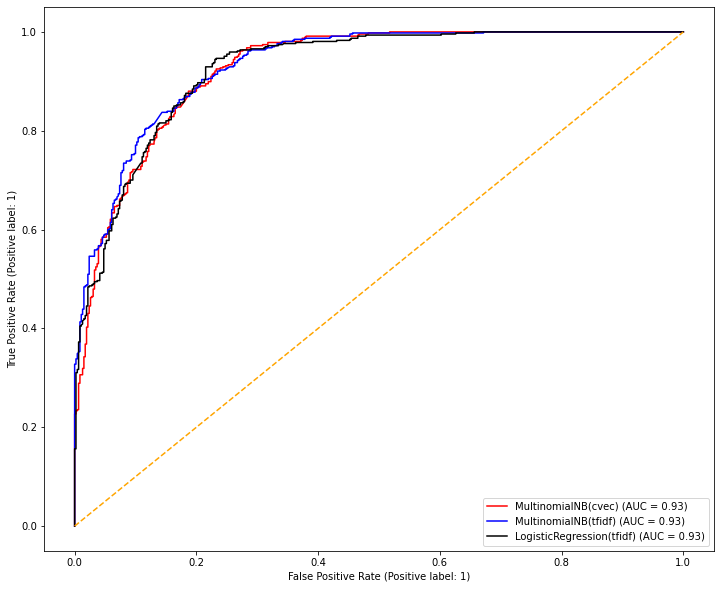

In [54]:
# plot top 3 performance models
fig, ax = plt.subplots(1, 1, figsize=(12,10))

# plot ROC curves 
plot_roc_curve(gs1, X_test, y_test, ax=ax, name='MultinomialNB(cvec)', color='red')
plot_roc_curve(gs2, X_test, y_test, ax=ax, name='MultinomialNB(tfidf)', color='blue')
plot_roc_curve(gs4, X_test, y_test, ax=ax, name='LogisticRegression(tfidf)', color='black')

# add worst case scenario line
plt.plot([0,1],[0,1], color = 'orange', linestyle='--')

# add a legend
plt.legend()

## Final model tuning
---

As mentioned above, **Multinomial Naive Bayes with CountVectorizer** will be our final model. We will try to improve our test accuracy of our final model even further through the use of the following text normalization methods namely: 
- Snowball Stemmer (stems words to a more accurate stem, which is an improvement to Porter Stemmer)
- Lemmatization

The general rule for whether to lemmatize/stem is unsurprising: if it does not improve performance, do not lemmatize/stem. Not lemmatizing/stemming is the conservative approach, and should be favored unless there is a **significant performance gain**. All preprocessing does not require lemmatizing/stemming for the eventual model or application to be effective and it may in fact impede the success or accuracy of the model or application. For example, a popular sentiment analysis method, VADER, has different ratings depending on the form of the word and therefore the input should not be stemmed or lemmatized.<sup>[(source)](https://opendatagroup.github.io/data%20science/2019/03/21/preprocessing-text.html)</sup>

In [55]:
# final model function
def final_model(df,column):
    # create input and output variables
    X = df[column]
    y = df['subreddit']

    # train-test-split
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)
    
    # create pipeline for vectorizer and estimator
    pipe = Pipeline([('cvec', CountVectorizer()),
                      ('nb', MultinomialNB())])
    
    # create pipeline parameters
    pipe_params = {
        'cvec__max_features': [None, 15_000], # selecting top N words from entire corpus
        'cvec__min_df':[2,3,4], # word must occur in at least N documents in corpus
        'cvec__max_df':[0.5,0.6,0.4], # ignore words that occur in >N% of the documents in corpus
        'cvec__ngram_range': [(1,1), (1,2)], # words from unigram / words from unigram + bigram
        'cvec__stop_words': [my_stop_words], # stopwords from sklearn + custom words
        'nb__fit_prior': [True, False]
    }
    
    # instantiate GridSearchCV
    gs = GridSearchCV(pipe, pipe_params, cv = 5)

    # fit gridsearch
    gs.fit(X_train, y_train)
    
    # evaluate model
    print(f"Train Score: {gs.score(X_train, y_train)}")
    print(f"Test Score: {gs.score(X_test, y_test)}")
    pred = gs.predict(X_test)
    plot_confusion_matrix(gs, X_test, y_test, cmap='BuPu', values_format='d', display_labels=['coffee', 'tea']);

### Lemmatization

In [56]:
# instantiate tokernizer and lemmatizer
w_tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

# create new dataframe for lemmatization
lemma_df = combined_df.copy(deep = True)

# function to lemmatize words in dataframe
def lemma_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

lemma_df['word_lemma'] = lemma_df['words'].apply(lemma_text)

# join all words with one spacing
lemma_df['word_lemma'] = lemma_df['word_lemma'].apply(lambda x: ' '.join(x))

# organize dataframe
lemma_df.drop('words',axis=1,inplace = True)
lemma_df.head()

,subreddit,word_lemma
0,0,Scaling 4:6 v60 method. Do I Also Scale Pour T...
1,0,"Search: Beans With Clear Stone Fruit Note, Pre..."
2,0,What would you say is the best common coffee b...
3,0,My New Years resolution is to make better coff...
4,0,Would you buy a coffee table book with beautif...


Train Score: 0.9053694843168527
Test Score: 0.8425026968716289


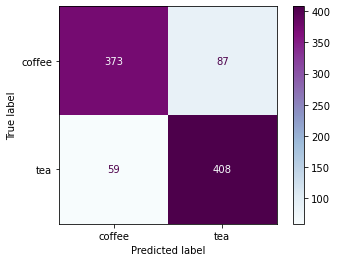

In [57]:
# run model and print evaluation metrics after lemmatization
final_model(lemma_df,'word_lemma')

Before Lemmatization:

|Train Score|Test Score|False Positives|False Negatives|
|---|---|---|---|
|0.903243|0.842503|86|60|

After Lemmatization:

|Train Score|Test Score|False Positives|False Negatives|
|---|---|---|---|
|0.905369|0.842503|87|59


Train score has increased by 0.2% while there was no increase in test score. This shows that lemmatization is ineffective in improving our final model's performance. Total false positives and false negatives have not decreased as well (total = 146). In addition, our model has become more overfitted than before albeit only very slightly. 

Therefore, we **will not** be using lemmatization.

### Snowball Stemmer

In [58]:
# instantiate stemmer 
sb = SnowballStemmer('english')

# create new dataframe for stemming
snow_df = combined_df.copy(deep = True)

# function to stem words in dataframe
def stem_text(text):
    return [sb.stem(w) for w in w_tokenizer.tokenize(text)]
snow_df['word_stemmed'] = snow_df['words'].apply(stem_text)

# join all words with one spacing
snow_df['word_stemmed'] = snow_df['word_stemmed'].apply(lambda x: ' '.join(x))

# organize dataframe
snow_df.drop('words',axis=1,inplace = True)
snow_df.head()

,subreddit,word_stemmed
0,0,scale 4:6 v60 method. do i also scale pour tim...
1,0,"search: bean with clear stone fruit note, pref..."
2,0,what would you say is the best common coffe br...
3,0,my new year resolut is to make better coffee. ...
4,0,would you buy a coffe tabl book with beauti pi...


Train Score: 0.9197235513024987
Test Score: 0.883495145631068


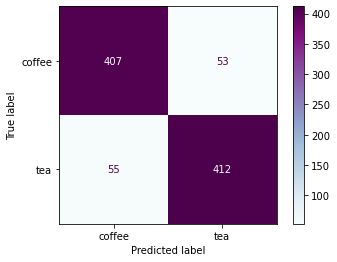

In [59]:
# run model and print evaluation metrics after stemming
final_model(snow_df,'word_stemmed')

Before Snowball Stemmer:

|Train Score|Test Score|False Positives|False Negatives|
|---|---|---|---|
|0.903243|0.842503|86|60|

After Snowball Stemmer:

|Train Score|Test Score|False Positives|False Negatives|
|---|---|---|---|
|0.919724|0.883495|53|55


Train score has increased by 1.6% while there is test score has increased by 4.1%. This shows that Snowball stemming is effective in improving our final model's performance. Total false positives and false negatives have also decreased as well (total = 108). This is a huge improvement in our model especially since Snowball stemming has managed to significantly reduce the overfit of our model. 

Therefore, we **will** be using Snowball stemmer as part of our final model.

## Final model interpretation and business insights
---

### <u>Top predictor words</u>

To interpret our Multinomial Naive Bayes model, we will be calculating the empirical log probability of features for a given class. In fact, to convert `log_probability` into an actual probability score, we would have to exponentiate the log_probability (i.e `np.exp(feature_log_prob)`). However, in this case, as what we are really interested in is to get the top 15 predictor words that are most important when classifying subreddit posts into either 'Coffee' or 'Tea'. just doing `log_probability` alone would suffice. 

Now, looking at the results below, some of the top predictive words for 'Tea' included matcha, loose leaf, teapot, herbal and green. This makes sense as these are usually words most talked about even by the average tea drinkers. Hence, these are also the words that we would be recommending for the marketing algorithm to pick up when deciding on which users to show the digital tea advertisements to.

Next, we have also calculated the coefficients of our Logistic Regression model, which was out 2nd best performing model. By looking at the coefficients, we can determine the words that are most related to r/Coffee and r/tea. 

In the case of 'Tea' for the Logistic Regression model, the top predictive words also included matcha, loose leaf and tea pot while also included some additional words such as japanese and chai. Overall, I am satisfied the the top predictive words for both the Multinomial NB and Logistic Regression model are consistent with one another. This would further reaffirm the words that would get recommended in the marketing algorithm to pick up to show tea advertisements for tea drinkers.

Similar for 'Coffee', the top predictive words for Multinomial NB included grinder, burr, v60, drip and aeropress while that of Logistic Refression included ginder, v60, pour and maker. We were also able to observe consistent predictive words between the models.

Lastly, with regards to our final model (Multinomial NB), we did not observe much overlap in top predictive words. This is also likely the reason why our test accuracy score was relatively high (88%). 

### Functions

In [91]:
# plot bar chart for tea
def feature_importance_tea(df, xdf, ydf):
    plt.figure(figsize=(10,8))
    sns.barplot(data=df, x=xdf, y=ydf, palette='Greens_r')
    plt.ylabel('')
    plt.title('Top 15 unigram predictive words for r/tea', fontsize=20);

# plot bar chart for coffee
def feature_importance_coffee(df, xdf, ydf):
    plt.figure(figsize=(10,8))
    sns.barplot(data=df, x=-xdf, y=ydf, palette='OrRd_r')
    plt.ylabel('')
    plt.title('Top 15 predictive words for r/Coffee', fontsize=20);

### Top 15 predictor words ( Final Model - Multinomial NB )

In [61]:
# vectorizer of top model with best params
# to take into account the contexts of the words, words from uni, bi and trigrams have been included
cvec = CountVectorizer(max_df = 0.5, max_features = None,\
                      min_df = 2, stop_words = my_stop_words, ngram_range=(1,3))

# input and output variables
X = snow_df['word_stemmed']
y = snow_df['subreddit']

# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

# fit and transform vectorizer on training data
X_train_cvec = cvec.fit_transform(X_train)

# get list of words tokenized by vectorizer
words = cvec.get_feature_names()

# instantiate top model with best params
nb = MultinomialNB()
nb.fit(X_train_cvec,y_train)

# getting relative feature importance for both classes
delta_log_prob = nb.feature_log_prob_[1,:] - nb.feature_log_prob_[0,:]

# get feature names
feature_names = cvec.get_feature_names()

# create dataframe
top_n_features = pd.DataFrame({'features': feature_names,
                              'feature importance': delta_log_prob})
top_n_features.sort_values(by=['feature importance'], inplace = True)

# split dataframe by classes (coffee and tea)
coffee_top_features = top_n_features.head(15).reset_index(drop=True)
tea_top_features = top_n_features.tail(15).sort_values(by=['feature importance'],\
                                                       ascending = False).reset_index(drop = True)

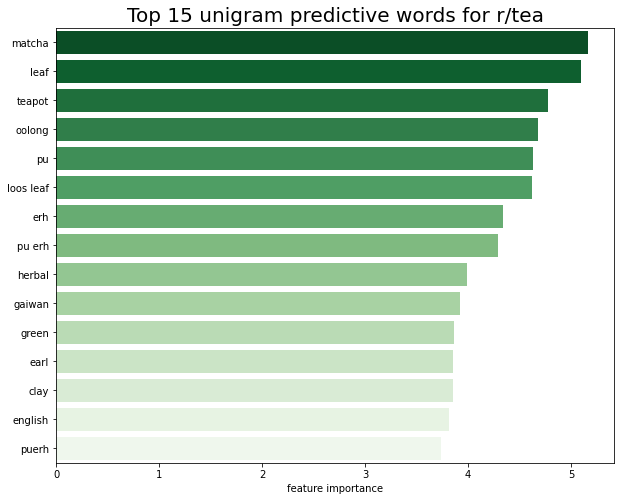

In [92]:
feature_importance_tea(tea_top_features, 'feature importance','features')

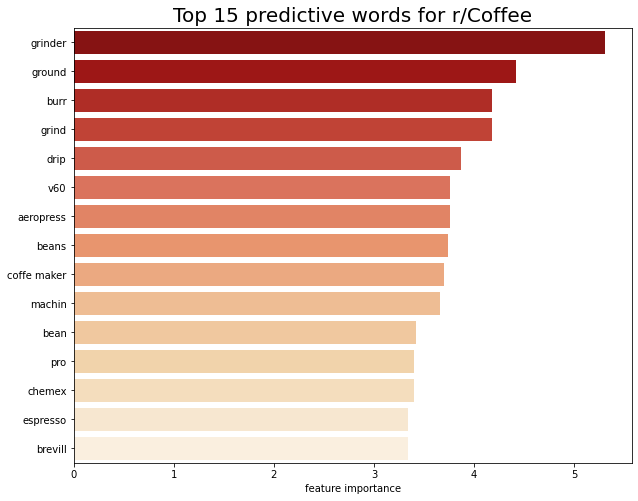

In [93]:
feature_importance_coffee(coffee_top_features, coffee_top_features['feature importance'],'features')

### Top 15 predictor words ( Logistic Regression - TfidfVectorizer)

In [64]:
gs4.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 2),
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow',

In [65]:
gs4.best_estimator_.steps[1][1]

LogisticRegression(class_weight='balanced', n_jobs=-1)

In [66]:
gs4.best_estimator_.steps[0][1]

TfidfVectorizer(max_df=0.5, min_df=2, ngram_range=(1, 2),
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}))

In [67]:
coef_df = pd.DataFrame(gs4.best_estimator_.steps[1][1].coef_).T
coef_df.columns = ['coef']
coef_df['words'] = gs4.best_estimator_.steps[0][1].get_feature_names()
coef_df= coef_df[['words','coef']]
coef_df = coef_df.sort_values(by=['coef'], ascending=False)


In [68]:
tea_coefs = coef_df.head(15).reset_index(drop=True)
coffee_coefs = coef_df.tail(15).sort_values(by=['coef'],ascending = True).reset_index(drop=True)

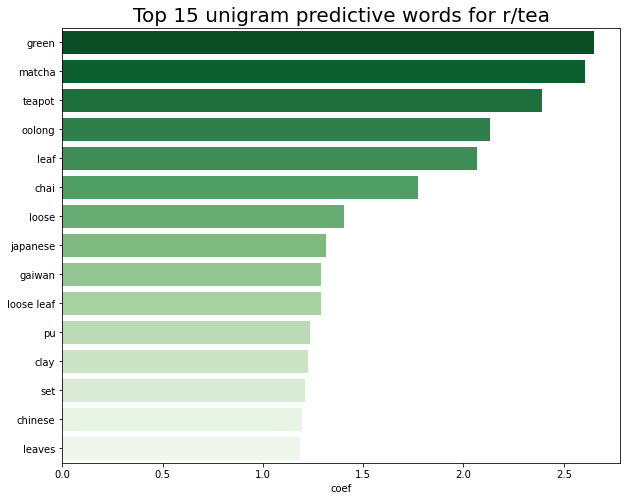

In [94]:
feature_importance_tea(tea_coefs, 'coef', 'words')

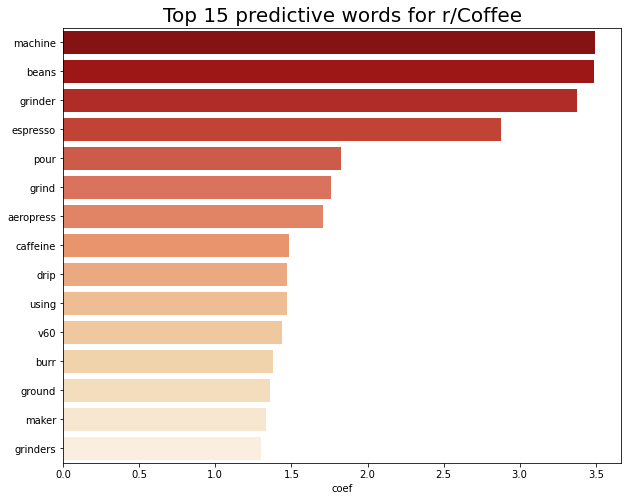

In [95]:
feature_importance_coffee(coffee_coefs, coffee_coefs['coef'], 'words')

## Wordcloud

In [71]:
tea_posts = list(snow_df[snow_df['subreddit'] == 1]['word_stemmed'])

In [72]:
coffee_posts = list(snow_df[snow_df['subreddit'] == 0]['word_stemmed'])

In [73]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(20, 14))
    plt.imshow(wordcloud)
    plt.axis("off");

Text(0.5, 1.0, 'r/Coffee')

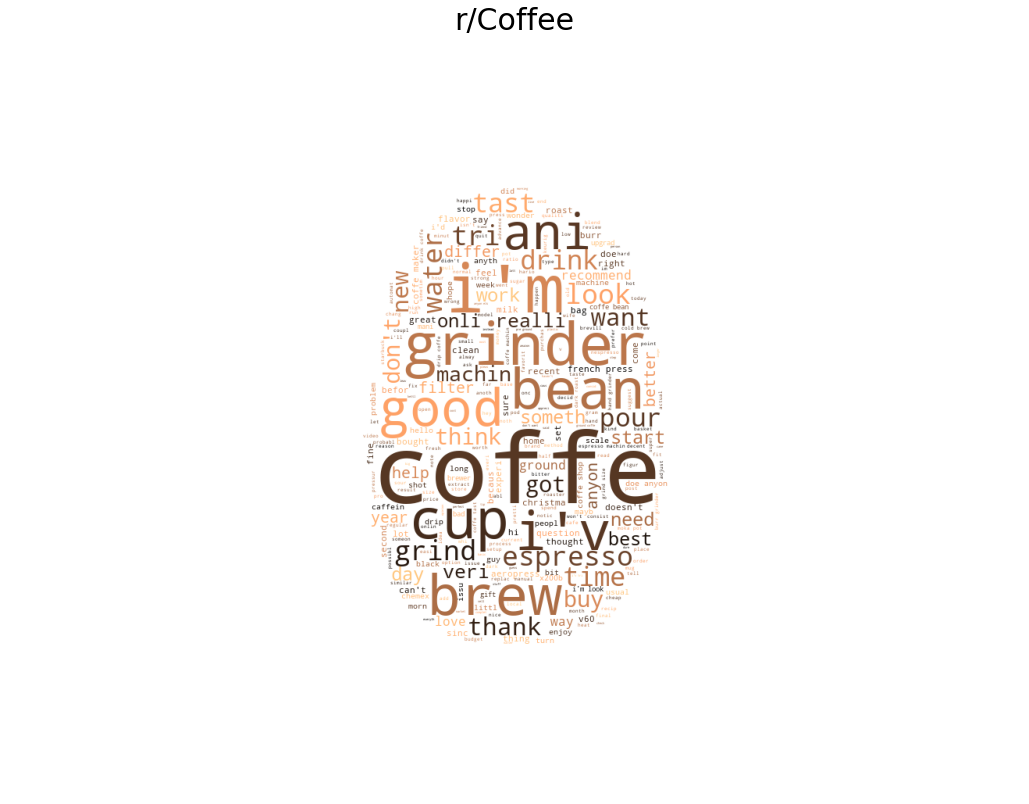

In [74]:
mask = np.array(Image.open("../Pictures/coffee-bean.png"))
coffee_wordcloud = WordCloud(
            width = 2000, height = 2000, stopwords= my_stop_words,mask=mask, random_state = 42,
            background_color = 'white',colormap='copper', max_words=300,
            max_font_size = 900).generate(' '.join(coffee_posts))

plot_cloud(coffee_wordcloud)
plt.title('r/Coffee', fontsize=30)


Text(0.5, 1.0, 'r/tea')

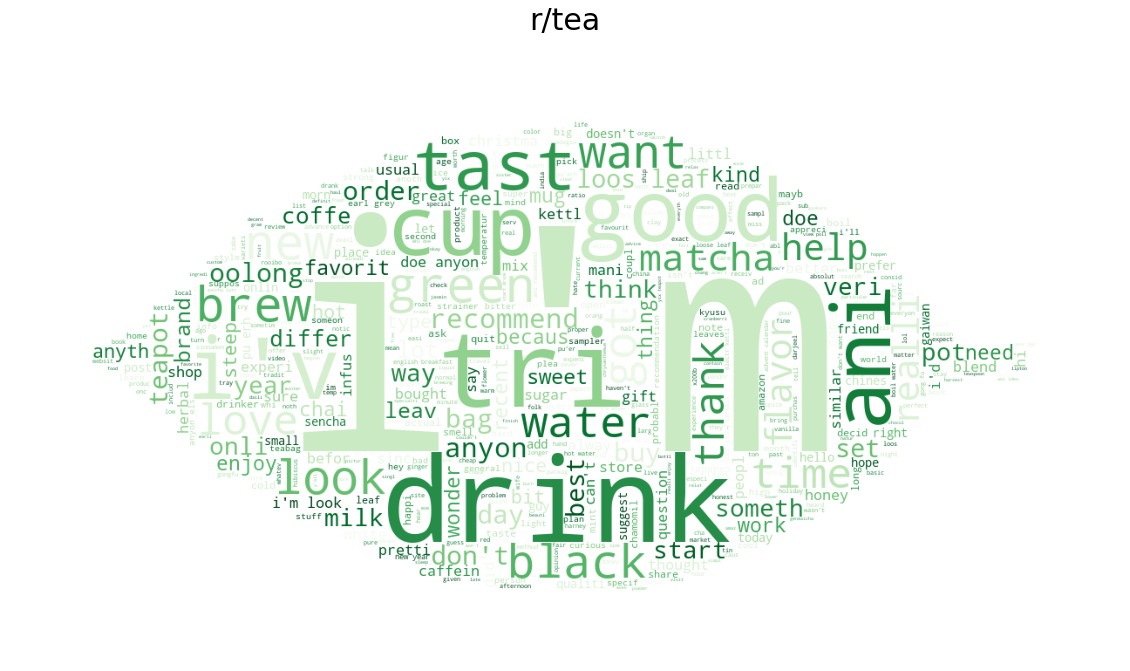

In [75]:
mask = np.array(Image.open("../Pictures/tea-leaf-3d-model-low-poly-max.png"))
tea_wordcloud = WordCloud(
            width = 2000, height = 2000, stopwords= my_stop_words, mask=mask, random_state = 42,
            background_color = 'white',colormap='Greens', max_words=500,
            max_font_size = 900).generate(' '.join(tea_posts))

plot_cloud(tea_wordcloud)
plt.title('r/tea', fontsize=30)


## Model limitations

We will examine the misclassified posts (i.e. false predictions) that our final model made since the primary objective of the model was to accurately predict which subreddit should the post belong to. If the model was unable to achieve this primary objective, it will be considered a limitation to our model. 

In [76]:
# fit final model and create dataframe with actual and predicted values
gs1.fit(X_train, y_train);
misclassified = pd.DataFrame({'actual': y_test,
                             'predicted': gs1.predict(X_test),
                            'text': X_test})

# create dataframe of all misclassified posts
misclassified = misclassified[misclassified['actual'] != misclassified['predicted']]
misclassified = misclassified.sort_values(by=['actual'], ascending = False)

# split into false positives and false negatives dataframes
misclassified_fn = misclassified.head()
misclassified_fp = misclassified.tail()

In [77]:
# false negatives: our model predicted post to be coffee instead of tea
for i in misclassified_fn['text']:
    print(i)
    print()

made a fresh pot of tea

thought on whi peopl are less into light roast / oxid season tea.

can you use matcha in an espresso puk/machin ?

the right cup of tea!

breakfast at dunk coffe in sevilla,tea and donut



> <font color = "darkblue"> 
We have chosen 5 out of 55 false negatives to review. False negatives are posts predicted to be coffee instead of tea. However, all 5 posts do indeed relate to tea and could provide useful information on the preferences of tea-drinkers and could have ended up as predictive words as well. Example 'fresh', 'light roast'
</font>

In [78]:
# false positives: our model predicted post to be tea instead of coffee
for i in misclassified_fp['text']:
    print(i)
    print()

dream hous

rate me. and be as harsh as you like

what is your feel toward vietnames milki coffee? i a/ i love it b/ it is just okay, mehhh c/ i heard about it but never tri befor d/ i don't even know if that is a thing e/ i dislik it

99% - 100% peopl do not know... tell your buddi lol [

how can i still enjoy coffe whilst be intolerant? a littl background: i absolut love coffee, most for the tast but also the cultur and energi boost. recent i have discov that i am probabl not intoler to caffeine, but to the bitter substanc within the coffee. at first i thought i was lactos intoler but my allergi test was negative, then i thought i might have a caffein intoler but i can consum everi type of caffein besid coffe and now i have last come to the conclus that i have to be intoler toward the bitter substances. right now i am feel sick, jitteri and fair exhausted, all becaus of one larg cup of cappuccino with milk. which realli sucks. my heart feel like it beat at 500 bpm (obvious exaggerate

> <font color = "darkblue"> 
We have chosen 5 out of 53 false positives to review. False positives are posts predicted to be tea instead of coffee. However, 2 posts do indeed relate to coffee and could provide useful information on the preferences of coffee-drinkers and could have ended up as predictive words. Example 'milk', 'bitter' and 'cuppuccino'.
</font>

## Recommendations on model

Areas for improvement:

- a bigger corpus that incorporates a larger set of vocabulary on the topics of coffee and tea. This could also be taken from other sites such as food review blogs and related Facebook groups
- as mentioned earlier, preferences in the Food & Beverage scene are ever-changing. In order for our model to maintain a comparatively high accuracy, it should ideally be re-trained at regular periods so that it does not contain out-of-date information and trends from coffee/tea drinkers, for example the 'Dalgona coffee' craze that took place at the start of COVID-19
- use word similarities (e.g. word2vec) to classify posts instead of frequency
- try other estimators like AdaBoost / GradientBoosting and try other vectorizers like lancaster Stemmer
- explore relationship between post content, number of comments, and upvote ratio
- use VADER (Valence Aware Dictionary and sEntiment Reasoner) lexicon to analyze the sentiments of posts


Future exploration:

- although the goal of this project is to classify subreddits, such a classification model can also be applied elsewhere, such as to e-commerce sites whereby such sites could process photos taken by shoppers when they saw something they fancied in real life. The processed photos will get classified into their respective categories and recommendations of similar products would be given to the shopper.